In [1]:
# 定义函数
import cupy as np
import numpy
import matplotlib.pyplot as plt

file = "inp.csv"

def init_data(src):
    """提取数据 x, y

    从文件中读取相应数据，年份 x, 总值 y

    Args:
        src (str): 文件路径

    Returns:
        array: 年份 x, 总值 y

    """
    pot = numpy.genfromtxt(src, delimiter=",")
    x = pot[:, 0]  # 第一列
    y = pot[:, 1]  # 第二列
    return np.array(x), np.array(y)


def genr(xs, ys, n):
    """生成矩阵

    根据多项式的次数，生成相应的矩阵

    Args:
        xs (array): x 数组
        ys (array): y 数组
        n  (int)  : 多项式的次数

    Returns:
        array: 对应的矩阵(matrix) X，Y

    """
    X, Y = [], []
    for x in xs:
        row = [x**i for i in range(n + 1)]  # X^i
        X.append(row)
    for y in ys:
        Y.append(y)
    return np.array(X), np.array(Y)


def calc(x, A, n):
    """计算 f(x)

    输出多项式曲线拟合的结果，即目标函数值

    Args:
        x (int)  : x 的值
        A (array): 多项式各项系数
        n (int)  : 多项式的次数

    Returns:
        float: 目标函数值

    """
    ret = 0.0
    for i in range(n + 1):
        ret += A[i] * x**i
    return ret


def draw(xs, ys, A, n, var=0):
    """绘图

    根据当前的计算结果，可视化多项式曲线拟合结果

    Args:
        xs (array): x 数组，真实数据
        ys (array): y 数组，真实数据
        A (array) : 多项式各项系数
        n (int)   : 多项式的次数
        var (int) : X 轴坐标点向右加值

    Returns:
        void: 无返回值
    
    """
    # 1*1 的网格，第 1 子图
    p = plt.figure().add_subplot(111)
    # 定义曲线的 X 轴坐标点
    X, Y = np.asnumpy(np.arange(min(xs) - 0.4, max(xs) + 1.2 + var, 0.01)), []
    for x in X:
        Y.append(calc(x, A, n).get())  # 对应的 f(x) 值
    xs = np.asnumpy(xs)
    ys = np.asnumpy(ys)
    p.plot(X, Y, color='r', linestyle='-', marker='', label='curve fit')
    p.plot(xs, ys, color='b', linestyle='', marker='.', label='data')
    # 最小二乘法拟合多项式 n 的函数曲线f (x)
    plt.legend()
    plt.title(n)  # 标题为当前次数
    plt.show()


def err(xs, ys, A, n):
    """计算误差

    根据当前的计算结果，计算误差平方和

    Args:
        xs (array): x 数组，真实数据
        ys (array): y 数组，真实数据
        A (array) : 多项式各项系数
        n (int)   : 多项式的次数

    Returns:
        float: 返回误差值

    """
    error = 0.0
    for i in range(len(xs)):
        error += (calc(xs[i], A, n) - ys[i])**2
    return error.get()


def solve(A):
    """解线性方程组

    利用列主元法解线性方程组

    Args:
        A (array): 线性方程组的矩阵形式

    Returns:
        array: 方程组的解

    """
    col = A.shape[1]  # 增广矩阵的列数
    for i in range(col - 2): # 遍历直至系数最后一
        current_column = A[i:, i] # 当前没消元的第 i 列
        max_index = np.argmax(current_column) + i  # 寻找当前列最大元
        temp = np.copy(A[i]) # 由于使用了 cupy 加速，故只能这样实现交换。numpy 下实现交换可用 A[[i,max_index],:] = A[[max_index,i],:]
        A[i] = A[max_index]
        A[max_index] = temp
        ratio = A[i + 1:, i] / A[i, i]  # 计算每一行相应的系数
        temp = np.tile(A[i, :], (ratio.shape[0], 1)) * np.tile(ratio, (col, 1)).T  # 计算消元时应当减去的矩阵
        A[i + 1:, :] = A[i + 1:, :] - temp  # 剩下的矩阵进行消元
    x = np.zeros(col - 1)
    for i in range(col - 2, -1, -1): # row = col - 1，从倒数第二行开始挨个计算
        x[i] = (A[i, -1] - A[i, :-1] @ x.T) / A[i, i] # 代入
    return x


[36, array(10337902.21602331)]
38 5500085.1008874215


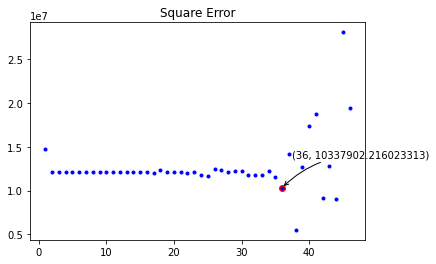

In [2]:
# 查看误差平方和
x, y = init_data(file)
ans = 0
anse = 2**128 + 1.1
xs, ys, tmp = [], [], []

for order in range(1, 47):
    X, Y = genr(x, y, order)
    W  = solve(np.column_stack((X.T @ X, X.T @ Y)))
    er = err(x, y, W, order)
    if (er < 1.1e7):  # 误差平方和小于 1.1e7
        tmp.append([order, er])
    xs.append(order)
    ys.append(er)
    if (er < anse):
        anse = er
        ans  = order

print(tmp[0])  # 第一个误差平方和小于 1.1e7 的
print(ans, anse)  # 最小误差平方和
# print(xs, ys)
# 输出图像
p = plt.figure().add_subplot(111)
p.plot(xs, ys, color='b', linestyle='', marker='.', label='err')  # 横坐标表示 x 次方程，纵坐标表示误差
p.annotate(r'({}, {})'.format(tmp[0][0], tmp[0][1]),
           xy=(tmp[0][0], tmp[0][1]), # 第一个误差平方和小于 1.5e9 的
           xycoords='data',
           xytext=(+10, +30),
           textcoords='offset points',
           arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3,rad=.2"))  # 添加注释
p.scatter([tmp[0][0]], [tmp[0][1]], 35, color='r')  # 将该点标红
plt.title('Square Error')
plt.show()

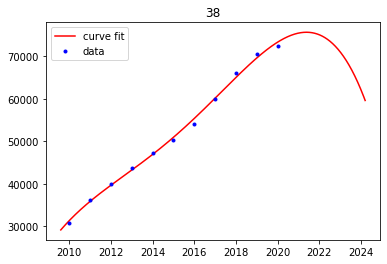

75443.80171203613


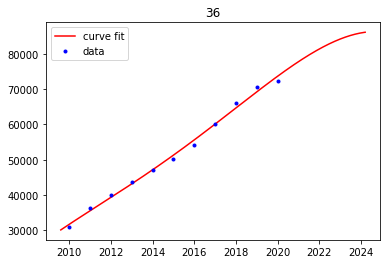

77790.14796566963


In [9]:
# 使用最小误差平方和的多项式次数，发现显然过拟合
X, Y = genr(x, y, ans)
W1 = solve(np.column_stack((X.T @ X, X.T @ Y)))
P = draw(x, y, W1, ans, 3)
print(calc(2021.0, W1, ans))

# 使用第一个误差平方和小于 1.5e9 的次数，发现曲线能较好拟合
X, Y = genr(x, y, tmp[0][0])
W = solve(np.column_stack((X.T @ X, X.T @ Y)))
P = draw(x, y, W, tmp[0][0], 3)
print(calc(2021.0, W, tmp[0][0]))

1 801.9333327151835


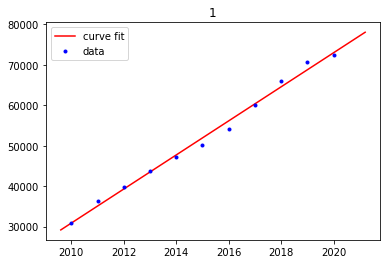

2021年中国国内生产总值预测 = 77205.89090956189
多项式参数 = [-8.43548495e+06  4.21211818e+03]


In [4]:
# 最小二乘拟合
# 由于 36 次前的误差都很接近，直接用最小误差可能不是一个好的方法
# 故使用前几年数据进行拟合，最后一年数据进行误差对比，选出最小误差
x, y = init_data(file)
ans1 = 0
anse1 = 2**64 + 1.1
xx = x[-1]  # x 的最后一个，即 2020 年
yy = y[-1]  # y 的最后一个，即 2020 年中国国内生产总值
x1 = x[:-1] # x 里删去最后一个
y1 = y[:-1] # y 里删去最后一个

for order in range(1, tmp[0][0]):
    X, Y = genr(x1, y1, order)
    W1 = solve(np.column_stack((X.T @ X, X.T @ Y)))
    er = abs(calc(xx, W1, order) - yy) # 拟合出来的值与准确值比较
    if (er < anse1): # 更新最小误差值
        anse1, ans1 = er, order

print(ans1, anse1) # 输出相应的次数与误差
X, Y = genr(x, y, ans1)
W1 = solve(np.column_stack((X.T @ X, X.T @ Y)))
P1 = draw(x, y, W1, ans1)
y1 = calc(2021, W1, ans1)
print('2021年中国国内生产总值预测 = {}'.format(y1))
print('多项式参数 = {}'.format(W1))

7 217.51012420654297


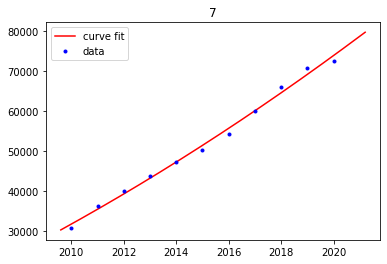

2021年中国国内生产总值预测 = 78651.3530625701
多项式参数 = [ 8.97716492e+01  6.40142957e+04  2.58055827e+01 -7.41522438e-02
  1.10375047e-05  8.67582535e-09 -2.30948407e-14 -7.09223393e-16]


In [5]:
# 添加 L2 正则，即使用岭回归
x, y = init_data(file)
ans2 = 0
anse2 = 2**64 + 1.1
xx = float(x[-1])
yy = y[-1]
x1 = x[:-1]
y1 = y[:-1]
Lambda = 0.0000001 # np.exp(-1) # 正则参数

for order in range(1, tmp[0][0]):
    X, Y = genr(x1, y1, order)
    W2 = solve(np.column_stack((X.T @ X + Lambda * np.eye(order + 1), X.T @ Y))) # L2 正则
    er = abs(calc(xx, W2, order) - yy)
    if (er < anse2):
        anse2, ans2 = er, order

print(ans2, anse2)
X, Y = genr(x, y, ans2)
W2 = solve(np.column_stack((X.T @ X + Lambda * np.eye(ans2 + 1), X.T @ Y)))
P2 = draw(x, y, W2, ans2)
y2 = calc(2021.0, W2, ans2)
print('2021年中国国内生产总值预测 = {}'.format(y2))
print('多项式参数 = {}'.format(W2))

35: 100%|██████████| 4001/4001 [03:36<00:00, 18.44it/s]
1.5399999999999998e-05 43.07112374213466


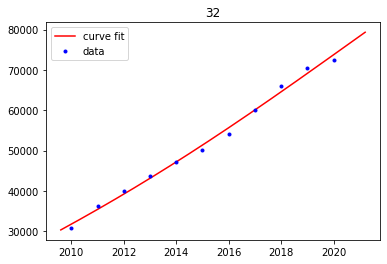

2021年中国国内生产总值预测 = 78395.70265388489
多项式参数 = [ 5.88187331e-04 -5.82323322e-03 -4.93923128e+00 -1.98075080e-01
  6.04276247e-05 -5.05745702e-10  5.98449963e-11 -3.00757604e-14
  4.59982076e-18  1.10508754e-20 -6.50708517e-24 -3.84190029e-28
 -2.15022783e-30  1.66676134e-34  7.06031223e-37 -5.91013524e-41
  3.42011119e-44  2.44790300e-47  7.64674518e-51 -1.21274963e-53
  2.32536830e-57 -6.74169619e-61 -1.38386598e-63 -1.02890498e-67
 -5.34281981e-71 -7.73215900e-74  4.10158934e-77  1.40236658e-80
  1.38668489e-84  1.15767044e-86 -1.16692723e-90  3.16236904e-94
 -8.17683758e-97]


In [6]:
# 交叉验证正则参数的较优选择，使用 GPU 优化
import tqdm

x, y = init_data(file)
ans3 = 0
ans4 = 0
anse3 = 2**64 + 1.1
xx = float(x[-1])
yy = y[-1]
x1 = x[:-1]
y1 = y[:-1]

for order in range(1, tmp[0][0]): # 枚举次数
    for Lambda in tqdm.tqdm(np.arange(0.0, 0.0004, 0.0000001), desc=str(order)): # 枚举正则参数
        X, Y = genr(x1, y1, order)
        W2 = solve(np.column_stack((X.T @ X + Lambda * np.eye(order + 1), X.T @ Y)))
        er = abs(calc(12.0, W2, order) - yy)
        if (er < anse3):
            anse3, ans3 = er, Lambda
            ans4 = order

print(ans3, anse3)
X, Y = genr(x, y, ans4)
W2 = solve(np.column_stack((X.T @ X + anse3 * np.eye(ans4 + 1), X.T @ Y)))
P2 = draw(x, y, W2, ans4)
y2 = calc(2021.0, W2, ans4)
print('2021年中国国内生产总值预测 = {}'.format(y2))
print('多项式参数 = {}'.format(W2))

2021 年中国人均国内生产总值预测 = 78353.31110286713
多项式参数 = [-6.36942223e-01  1.07883021e+03 -1.13872481e+03 -2.49888728e-02
  1.47132501e-04  2.28793108e-08  7.76225199e-11  4.04991478e-14
 -1.91086998e-17  1.78322183e-21  7.43776143e-25 -3.40123639e-27
  1.26859272e-30 -6.92280555e-34 -1.86546072e-37  1.09047292e-40
  2.86402663e-44 -8.45635603e-48 -1.02747930e-50  2.76923272e-54
 -1.03030219e-57  2.11143435e-60  7.36188114e-64 -5.15299910e-67
 -7.79568233e-71 -2.55496547e-74  2.22491097e-77  2.08229640e-80
 -8.76100348e-84 -3.82037131e-88  6.60497810e-91  8.37343142e-94
 -4.79005749e-97]


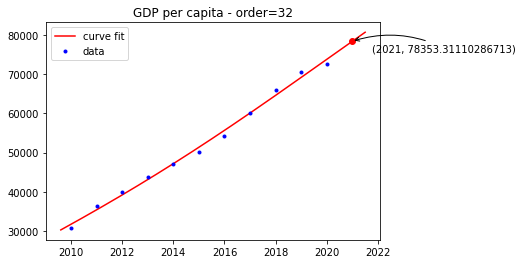

In [15]:
# 最终结论
Lambda = 1.5399999999999998e-05
Order  = 32
x, y = init_data(file)
X, Y = genr(x, y, Order)
W3 = solve(np.column_stack((X.T @ X + Lambda * np.eye(Order + 1), X.T @ Y)))
# P3 = draw(x, y, W3, Order)
y3 = calc(2021.0, W3, Order).get()
print('2021 年中国人均国内生产总值预测 = {}'.format(y3))
print('多项式参数 = {}'.format(W3))

p = plt.figure().add_subplot(111)
# 定义曲线的 X 轴坐标点
X, Y = np.asnumpy(np.arange(min(x) - 0.4, max(x) + 1.5, 0.01)), []
for i in X:
    Y.append(calc(i, W3, Order).get())  # 对应的 f(x) 值
x = np.asnumpy(x)
y = np.asnumpy(y)
p.plot(X, Y, color='r', linestyle='-', marker='', label='curve fit')
p.plot(x, y, color='b', linestyle='', marker='.', label='data')
# 最小二乘法拟合多项式 n 的函数曲线f (x)
p.annotate(r'({}, {})'.format(2021, y3),
           xy=(2021, y3), # 第一个误差平方和小于 1.5e9 的
           xycoords='data',
           xytext=(+20, -10),
           textcoords='offset points',
           arrowprops=dict(arrowstyle="->",
                           connectionstyle="arc3,rad=.2"))  # 添加注释
p.scatter([2021], [y3], 35, color='r')  # 将该点标红
plt.legend()
plt.title('GDP per capita - order=' + str(Order))  # 标题为当前次数
plt.show()